

En este post vamos a presentar un ejemplo de un pipeline de modelado predictivo típico usando datos tabulares, es decir, que pueden ser estructurados en una tabla de 2 dimensiones. En primer lugar, analizaremos el dataset usado y posteriormente entrenaremos un primer pipeline predictivo. Después prestaremos atención a los tipos de datos que tiene que manejar nuestro modelo: numéricos y categóricos. Por último, extenderemos nuestro pipeline para tipos de datos mixtos, es decir, numéricos y categóricos.

El objetivo a conseguir es construir intuiciones respecto a un dataset desconocido, identificar y discriminar *features* numéricas y categóricas y, finalmente, crear un pipeline predictivo avanzado con *scikit-learn*.

En concreto mostraremos los siguientes aspectos:

+ identificar datos númericos en un dataset heterogéneo
+ seleccionar el subconjunto de columnas correspondientes a datos numéricos
+ usar la función de scikit-learn `train_test_split` para dividir los datos en entrenamiento y prueba
+ entrenar y evaluar un modelo de regresión logística
+ la importancia de evaluar el rendimiento de generalización en los datos de prueba
+ usar un predictor dummy para obtener una línea base de referencia
+ ver la importancia de escalar las variables numéricas
+ usar un pipeline para encadenar el escalado y el entrenamiento de una regresión logística
+ evaluar el rendimiento de generalización de nuestro modelo a partir de validación cruzada
+ mostrar las dos estrategias comunes para codificar variables categóricas: `ordinal` y `one-hot`
+ usar un pipeline para utilizar un codificador one-hot antes de entrenar un predictor
+ usar un `ColumnTransformer` para aplicar preprocesamientos diferentes a variables numéricas y categóricas
+ usar un pipeline para encadenar el preprocesamiento `ColumnTransformer` y entrenar una regresión logística

# Primer vistazo al dataset

Antes de llevar a cabo cualquier tarea de machine learning hay que realizar un serie de pasos:

+ cargar los datos.
+ observar las variables del dataset, diferenciando entre variables numéricas y categóricas, las cuales necesitarán un preprocesamiento diferente en la mayoría de los flujos de machine learning.
+ visualizar la distribución de las variables para obtener algún tipo de conocimiento o idea del dataset.

Usaremos el dataset "**credit-g**". Para más detalles sobre dicho dataset puedes acceder al link [https://www.openml.org/d/31](https://www.openml.org/d/31). El objetivo del dataset es clasificar a las personas por un conjunto de atributos como buenas o malas respecto al riesgo crediticio. Los datos están disponibles en un fichero CSV y usaremos pandas para leerlo. 

In [1]:
import numpy as np
import pandas as pd

credit = pd.read_csv("../data/credit-g.csv")

## Las variables del dataset

Los datos se almacenan en un *dataframe* de pandas. Un dataframe es una estructura de datos de 2 dimensiones. Este tipo de datos también se denominan datos tabulares. 

Cada fila representa un "ejemplo". En el campo de machine learning se usan normalmente los términos equivalentes de "registro", "instancia" u "observación". 

Cada columna representa un tipo de información que ha sido recopilada y se denominan "features". En el campo de machine learning es normal usar los términos equivalentes de "variable", "atributo" o "covariable".

Echemos un vistazo rápido al dataframe para mostrar las primeras filas:

In [2]:
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [3]:
credit.shape

(1000, 21)

El dataset está compuesto de 1.000 instancias y 21 variables. La columna llamada `class` es nuestra variable objetivo (es decir, la variable que queremos predecir). Las dos posibles clases son `good` (bajo riesgo credicitio) y `bad` (alto riesgo crediticio). El problema de predicción resultante es, por tanto, un problema de clasificación binaria. Usaremos el resto de columnas como variables de entrada para nuestro modelo.

In [4]:
credit["class"].value_counts()

good    700
bad     300
Name: class, dtype: int64

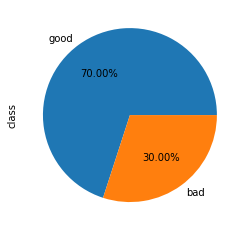

In [5]:
credit["class"].value_counts().plot.pie(autopct='%1.2f%%');

Vemos que las clases están desbalanceadas, lo que significa que tenemos más instancias de una o más clases comparada con las otras. El desequilibro de clases sucede frecuentemente en la práctica y puede requerir de técnicas especiales al construir el modelo predictivo. Veremos este tipo de técnicas en otros posts.

In [6]:
credit.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

In [7]:
credit.dtypes.value_counts()

object    14
int64      7
dtype: int64

Comprobamos que el dataset contiene tanto datos numéricos (7 features) como categóricos (14 features, incluyendo la variable objetivo). En este caso sus tipos son `int64` y `object`, respectivamente.

## Inspección visual de los datos

Antes de construir cualquier modelo predictivo es buena idea echar un vistazo a los datos:

+ quizás la tarea que estamos intentando conseguir se pueda resolver sin utilizar machine learning;
+ debemos comprobar que la información que necesitamos se encuentra presente realmente en el dataset;
+ inspeccionar los datos en una buena forma de encontrar peculiaridades. Estas pueden aparecer durante la recolección de los datos (por ejemplo, debido al malfuncionamiento de sensores o valores faltantes) o en la forma en que los datos son procesados posteriormente (por ejemplo, valores "capados").

Echemos un vistazo a las distribuciones de las features individualmente para obtener algún conocimiento adicional sobre los datos. Podemos empezar dibujando histogramas, aunque esto solo aplicaría a las features numéricas:

C:\Program Files\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


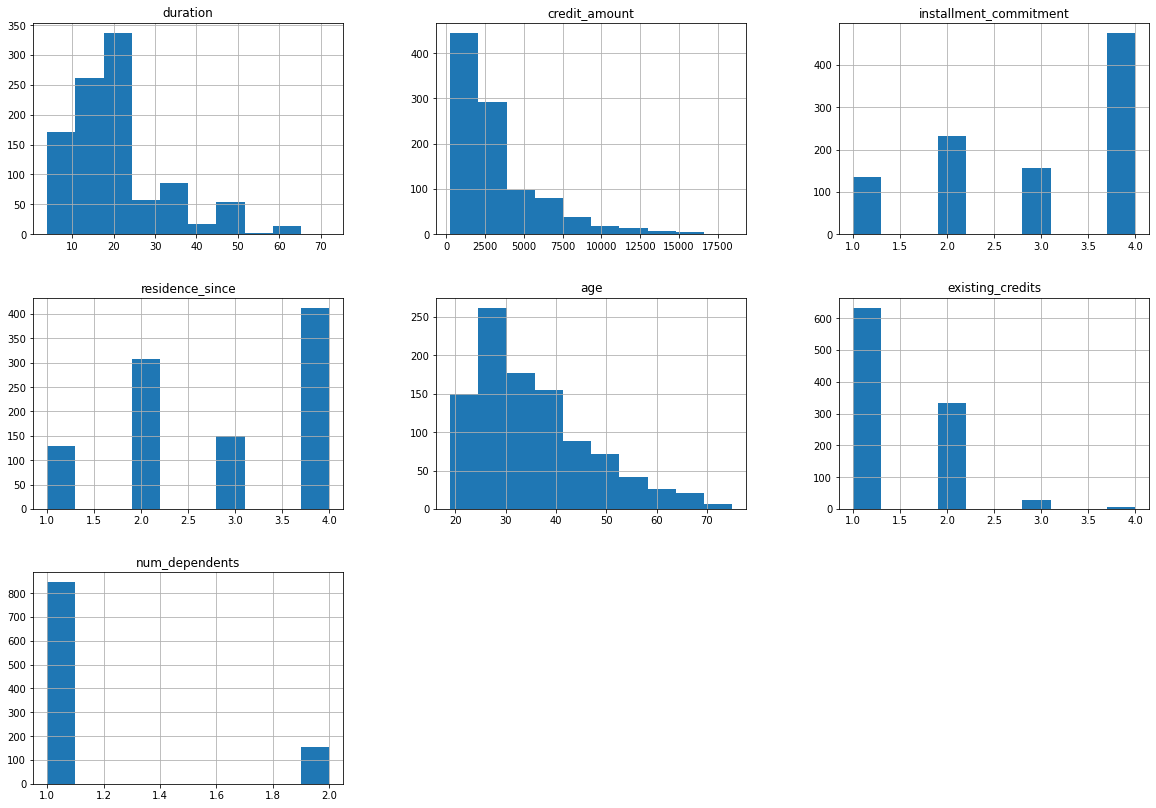

In [8]:
_ = credit.hist(figsize=(20, 14))

Algunos comentarios sobre estas variables:

+ `duration`: la mayoría de las personas a las que se les concede el crédito su duración está entre aproximadamente 4 y 24 meses, principalmente entre 12 y 24 meses.
+ `credit_amount`: la mayoría de las personas solicita un crédito menor de 4.000 aproximadamente.
+ `age`: la mayoría de las personas que solicitan un crédito son menores de 40 años.


Veamos la distribución de algunas variables categóricas:

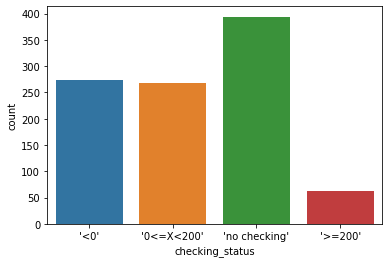

In [9]:
import seaborn as sns

_ = sns.countplot(x="checking_status", data=credit)

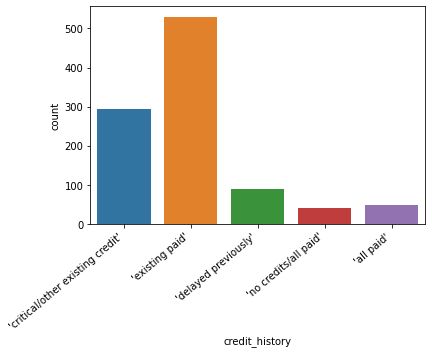

In [10]:
ax = sns.countplot(x="credit_history", data=credit)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

Bueno, hasta ahora hemos visto cómo cargar un dataset, calcular su tamaño y visualizar de forma rápida las primeras filas del mismo. En un primer análisis de las variables que lo componen, hemos identificado nuestra variable objetivo y diferenciado las variables numéricas y categóricas. También hemos podido observar cómo se distribuyen sus valores.

# Modelo simple con scikit-learn

Vamos a crear un primer modelo predictivo, para lo cual solo usaremos las variables numéricas. Los datos numéricos son el tipo de datos más natural en machine learning y (casi) pueden incorporarse directamente a los modelos predictivos.

Como hemos visto, el archivo CSV contiene toda la información que necesitamos: el objetivo que nos gustaría predecir (es decir, `class`) y los datos que queremos usar para entrenar nuestro modelo predictivo (es decir, las columnas restantes). El primer paso es separar las columnas para obtener de un lado el objetivo y del otro lado los datos.

## Separar los datos y el objetivo

In [11]:
target_name = "class"
y = credit[target_name]
data = credit.drop(columns=[target_name])

Vamos a usar una función de sklearn que nos permite seleccionar las columnas en función del tipo de dato.

In [12]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_include=np.number)
numerical_columns = numerical_columns_selector(data)
numerical_columns

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [13]:
X = data[numerical_columns]
X.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2


## Entrenar un modelo y hacer predicciones

Vamos a construir un modelo de clasificación usando *regresión logística*, que pertenece a la familia de los modelos lineales. 

Brevemente, los modelos lineales buscan un conjunto de pesos para combinar linealmente las features y predecir el objetivo. Por ejemplo, el modelo puede generar un regla como la siguiente:

+ si `0.1 * duration + 3.3 * credit_amount - 15.1 * installment_commitment + 3.2 * residence_since - 0.2 * age + 1.3 * existing_credits - 0.9 * num_dependents + 13.2 > 0`, predice `good`

+ en caso contrario predice `bad`

El metodo `fit` se llama para entrenar el modelo a partir de los datos de entrada (features) y objetivo.

In [14]:
from sklearn import set_config
set_config(display="diagram")

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(X, y)

LogisticRegression(max_iter=500)

El proceso de aprendizaje puede representarse de la siguiente forma:

![](images/model_fit.png)

El método `fit`se compone de dos elementos: un algoritmo de aprendizaje y algunos estados del modelo. El algoritmo de aprendizaje toma los datos y el objetivo de entrenamiento como entrada y establece los estados del modelo. Estos estados del modelo se utilizarán posteriormente para predecir (por clasificadores o regresores) o transformar los datos (por transformadores).

Tanto el algoritmo de aprendizaje como el tipo de estados del modelo son específicos para cada tipo de modelo.

Usaremos ahora nuestro modelo para llevar a cabo algunas predicciones usando el mismo dataset.

In [16]:
y_predicted = model.predict(X)

El mecanismo de predicción puede representarse de la siguiente forma:

![](images/model_predict.png)

Para predecir, un modelo usa una **función de predicción** que utilizará los datos de entrada junto con los estados del modelo. Como el algoritmo de aprendizaje y los estados del modelo, la función de predicción es específica para cada tipo de modelo.

Vamos a revisar las predicciones calculadas. Por simplicidad vamos a echar un vistazo a los primeros cinco objetivos predichos.

In [17]:
y_predicted[:5]

array(['good', 'bad', 'good', 'good', 'good'], dtype=object)

De hecho, podemos comparar estas predicciones con los datos reales:

In [18]:
y[:5]

0    good
1     bad
2    good
3    good
4     bad
Name: class, dtype: object

e incluso podríamos comprobar si las predicciones concuerdan con los objetivos reales:

In [19]:
y_predicted[:5] == y[:5]

0     True
1     True
2     True
3     True
4    False
Name: class, dtype: bool

In [20]:
print(f"Nº de predicciones correctas: {(y_predicted[:5] == y[:5]).sum()} de las 5 primeras")

Nº de predicciones correctas: 4 de las 5 primeras


En este caso, parece que nuestro modelo comete un error al predecir la quinta instancia. Para obtener un mejor evaluación podemos calcular la tasa promedio de éxito:

In [21]:
(y_predicted == y).mean()

0.706

¿Podemos confiar en esta evaluación? ¿Es buena o mala?

## División de los datos en entrenamiento y prueba

Cuando construimos un modelo de machine learning es muy importante evaluar el modelo entrenado en datos que no se hayan usado para entrenarlo, ya que la **generalización** es más que la memorización (significa que queremos una regla que generalice a nuevos datos, sin comparar los datos memorizados). Es más difícil concluir sobre datos nunca vistos que sobre los ya vistos.

La evaluación correcta se realiza fácilmente reservando un subconjunto de los datos cuando entrenamos el modelo y usándolos posteriormente para evaluar el modelo. Los datos usados para entrenar un modelo se denominan **datos de entrenamiento** mientras que los datos usados para evaluar el modelo se denominan **datos de prueba**.

En ocasiones podemos contar con dos datasets separados, uno para el entrenamiento y otro para pruebas. Sin embargo, esto suele ser bastante inusual. La mayoría de las veces tendremos un único archivo que contiene todos los datos y necesitaremos dividirlo una vez cargado en memoria.

Scikit-learn proporciona la función `sklearn.model_selection.train_test_split`, que usaremos para dividir automáticamente el dataset en dos subconjuntos.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.20)

Cuando llamamos a la función `train_test_split`, especificamos que queremos tener el 20% de las instancias en el conjunto de prueba y las instancias restantes (80%) estarán disponibles para el conjunto de entrenamiento.

## Establecimiento de una línea base

Para avaluar el rendimiento de nuestro modelo predictivo resulta de utilidad establecer una línea base simple. La línea base más simple para un clasificador es aquella que predice siempre la misma clase, independientemente de los datos de entrada. Para ello usaremos un `DummyClassifier`.

In [23]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(strategy="most_frequent", random_state=42)

In [24]:
clf_dummy.fit(X_train, y_train)
accuracy_dummy = clf_dummy.score(X_test, y_test)
print(f"Accuracy línea base: {accuracy_dummy}")

Accuracy línea base: 0.705


Este clasificador dummy predice siempre la clase más frecuente (en nuestro caso, la clase `good`). Como vimos anteriormente la proporción de clase `good` era del 70%, que coincide con la puntuación obtenido por este clasificador. Bien, ya tenemos una linea base con la que comparar nuestro modelo.

Vamos a entrenar el modelo exactamente de la misma forma que vimos anteriormente, excepto que usaremos para ello los subconjuntos de entrenamiento:

In [25]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

En lugar de calcular la predicción y calcular manualmente la tasa media de éxito, podemos usar el método `score`. Cuando se trata de clasificadores este método devuelve su métrica de rendimiento.

In [26]:
accuracy_lgr = model.score(X_test, y_test)
print(f"Accuracy: {accuracy_lgr:.3f}")

Accuracy: 0.740


Veamos el mecanismo subyacente cuando se llama al método `score`:

![](images/model_score.png)

Para calcular la puntuación, el predictor primero calcula las predicciones (usando el metodo `predict`) y luego usa una función de puntuación para comparar los objetivos reales y las predicciones. Por último, se devuelve la puntuación.

Por norma general, nos referimos al **rendimiento de generalización** de un modelo cuando nos refiramos a la puntuación de prueba o al error de prueba obtenido al comparar la predicción de un modelo con los objetivos reales. También son términos equivalentes rendimiento predictivo y rendimiento estadístico. Nos referimos al **rendimiento computacional** de un modelo predictivo cuando accedemos al coste computacional de entrenar un modelo predictivo o usarlo para hacer predicciones.

Bueno, la puntuación de nuestro modelo apenas mejora la linea base que establecimos:

In [27]:
print(f"Accuracy línea base = {accuracy_dummy}")
print(f"Accuracy regresión logística = {accuracy_lgr}")

Accuracy línea base = 0.705
Accuracy regresión logística = 0.74


Seguro que podemos hacerlo mejor. Veamos cómo.

# Preprocesamiento de features numéricas

En los siguientes apartados vamos a introducir el uso del preprocesamiento, en este caso del **escalado de variables numéricas**; y del uso de un pipeline para encadenar el preprocesamiento y el entrenamiento del modelo.

Scikit-learn cuenta con una amplia gama de algoritmos de preprocesamiento que nos permiten transformar los datos de entrada antes de entrenar un modelo. Es este caso, vamos a estandarizar los datos y después entrenaremos un nuevo modelo de regresión logística es esta nueva versión del dataset.

En primer lugar, vamos a mostrar algunas estadísticas sobre los datos de entrenamiento.

In [28]:
X_train.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,21.095000,3360.618750,2.965000,2.846250,35.558750,1.411250,1.143750
std,11.807211,2898.174863,1.122653,1.105277,11.411587,0.578828,0.351056
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1380.000000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2333.000000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,4154.500000,4.000000,4.000000,42.000000,2.000000,1.000000
max,60.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Observamos que las features del dataset abarcan diferentes rangos. Algunos algoritmos hacen suposiciones con respecto a las distribuciones de las features y, en general, la normalización de estas features resultará de utilidad para abordar estas suposiciones. Algunas razones para el escalado de features son las siguientes:

+ Los modelos basados en distancias entre pares de instancias, por ejemplo, k-nearest neighbors, deben ser entrenados con features normalizadas para hacer que cada feature contribuya aproximadamente por igual a los cálculos de distancias.

+ Muchos modelos, como la regresión logística usan solucionadores numéricos (basados en descenso de gradiente) para encontrar sus parámetros óptimos. Este solucionador converge más rápido cuando las features están escaladas.

El hecho de que un modelo de machile learning requiera o no de escalado de features depende de la familia del modelo. Los modelos lineales como la regresión logística generalmente se benefician del escalado mientras que otros modelos como los árboles de decisión no necesitan de este preprocesado (pero tampoco se verían penalizados).

Vamos a mostrar cómo aplicar tal normalización usando un transformador de scikit-learn llamado `StandardScaler`. Este transformador escala cada feature individualmente para que todas tengan media 0 y desviación estándar 1. Analizaremos los diferentes pasos usados por scikit-learn para conseguir esta transformación de los datos.

Lo primero que necesitamos es llamar al método `fit` para que aprenda el escalado de los datos.

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

El método `fit` de los transformadores es similar al método `fit` de los predictores. La diferencia principal es que el transformador tiene un único argumento, la matriz de datos, mientras que el último tiene dos argumentos, la matriz de datos y el objetivo). En este caso, el algoritmo necesita calcular la media y la desviación típica de cada feature y almacenarla en algunas arrays de Numpy. Aquí, estos estadísticos son los estados del modelo. El hecho de que los estados del modelo de este scaler sean arrays de medias y desviaciones típicas es específico del `StandardScale`. Otros transformadores de scikit-learn calcularán diferentes estadísticos y los almacenarán como estados del modelo de la misma forma.

Vamos a inspeccionar las medias y desviaciones típicas calculadas.

In [30]:
scaler.mean_

array([2.10950000e+01, 3.36061875e+03, 2.96500000e+00, 2.84625000e+00,
       3.55587500e+01, 1.41125000e+00, 1.14375000e+00])

In [31]:
scaler.scale_

array([1.17998294e+01, 2.89636294e+03, 1.12195142e+00, 1.10458632e+00,
       1.14044530e+01, 5.78466453e-01, 3.50836055e-01])

Ya sabemos, por convención de scikit-learn, que si un atributo aprende de los datos, su nombre termina con `_`, como `mean_` y `scale_` para el `StandardScaler`.

El escalado de los datos se aplica a cada feature de forma individual. Para cada feature, restamos su media y dividimos por su desviación típica. Una vez que hemos llamado al método `fit` podemos ejecutar la transformación llamando al método `transform`.

In [32]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[ 3.29708155,  1.19991221,  0.03119565, ...,  2.4061873 ,
         1.01777726, -0.40973554],
       [-0.00805096, -0.35962991, -0.86010854, ..., -0.22436411,
        -0.71093146, -0.40973554],
       [-1.27925578, -0.73354714, -0.86010854, ...,  1.26628169,
        -0.71093146, -0.40973554],
       ...,
       [ 0.24619   ,  0.84360327,  0.92249983, ..., -0.7504744 ,
         1.01777726, -0.40973554],
       [-0.77077385, -0.64792251, -0.86010854, ..., -0.92584449,
        -0.71093146, -0.40973554],
       [-1.27925578, -0.83850636,  0.03119565, ..., -1.01352954,
        -0.71093146, -0.40973554]])

Vamos a analizar el mecanismo interno del método `transform` y lo pondremos en perspectiva con lo que ya vimos con los predictores.

![](images/transformer_transformer.PNG)

El método `transform` para los transformadores es similar al método `predict` para los predictores. Usa una función predefinida, llamada **función de transformación**, y usa los estados del modelo y los datos de entrada. Sin embargo, en lugar de devolver predicciones, el trabajo del método `transform` es devolver una versión transformada de los datos de entrada.

Por último, el método `fit_transform` es un método abreviado para llamar sucesivamente a `fit`y después a `transform`.

![](images/transform_fit_transform.PNG)

In [33]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[ 3.29708155,  1.19991221,  0.03119565, ...,  2.4061873 ,
         1.01777726, -0.40973554],
       [-0.00805096, -0.35962991, -0.86010854, ..., -0.22436411,
        -0.71093146, -0.40973554],
       [-1.27925578, -0.73354714, -0.86010854, ...,  1.26628169,
        -0.71093146, -0.40973554],
       ...,
       [ 0.24619   ,  0.84360327,  0.92249983, ..., -0.7504744 ,
         1.01777726, -0.40973554],
       [-0.77077385, -0.64792251, -0.86010854, ..., -0.92584449,
        -0.71093146, -0.40973554],
       [-1.27925578, -0.83850636,  0.03119565, ..., -1.01352954,
        -0.71093146, -0.40973554]])

In [34]:
X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=X_train.columns)
X_train_scaled.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02
mean,9.769963e-17,-1.776357e-17,1.465494e-16,2.664535e-17,-3.075318e-16,2.242651e-16,-8.437695e-17
std,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00
min,-1.448750e+00,-1.073974e+00,-1.751413e+00,-1.671440e+00,-1.451955e+00,-7.109315e-01,-4.097355e-01
25%,-7.707739e-01,-6.838296e-01,-8.601085e-01,-7.661239e-01,-7.504744e-01,-7.109315e-01,-4.097355e-01
50%,-2.622919e-01,-3.547963e-01,3.119565e-02,1.391924e-01,-2.243641e-01,-7.109315e-01,-4.097355e-01
75%,2.461900e-01,2.740959e-01,9.224998e-01,1.044509e+00,5.648013e-01,1.017777e+00,-4.097355e-01
max,3.297082e+00,5.200792e+00,9.224998e-01,1.044509e+00,3.458408e+00,4.475195e+00,2.440599e+00


Observemos que la media de todas las columnas es cercana a 0 y la desviación típica en todos los casos es cercano a 1. Podemos visualizar el efecto de `StandarScaler` usando un joinplot para mostrar ambos histogramas de distribución y un scatterplot de cada par de features numéricas al mismo tiempo. Observamos que `StandardScaler` no cambia la estructura de los datos en si mismos sino que los ejes han sido desplazados y escalados.

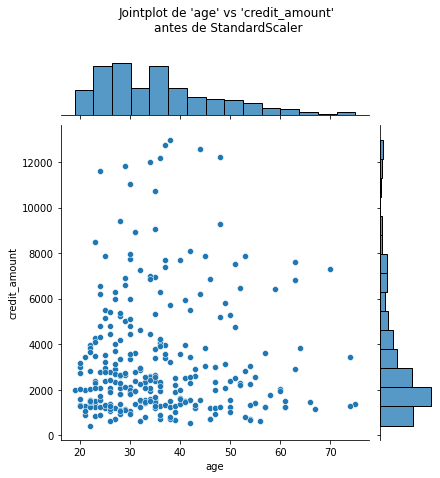

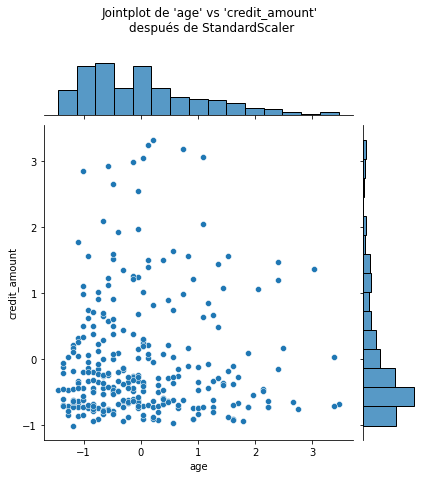

In [35]:
import matplotlib.pyplot  as plt

# number of points to visualize to have a clearer plot
num_points_to_plot = 300

sns.jointplot(data=X_train[:num_points_to_plot], x="age",
              y="credit_amount", marginal_kws=dict(bins=15))
plt.suptitle("Jointplot de 'age' vs 'credit_amount' \nantes de StandardScaler", y=1.1)

sns.jointplot(data=X_train_scaled[:num_points_to_plot], x="age",
              y="credit_amount", marginal_kws=dict(bins=15))
_ = plt.suptitle("Jointplot de 'age' vs 'credit_amount' \ndespués de StandardScaler", y=1.1)

Podemos combinar fácilmente operaciones secuenciales con un `pipeline` de scikit-learn, que encadena juntas operaciones y se usa como cualquier otro clasificador o regresor. La función `make_pipeline` creará un `Pipeline`: toma como argumentos las sucesivas transformaciones a ejecutar, seguido por el modelo clasificador o regresor.

In [36]:
import time
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

La función `make_pipeline` no requiere que demos un nombre a cada paso. De hecho, se lo asigna automáticamente basado en el nombre de la clase suministrada; un `StandardScaler` tendrá un paso llamado `"standardscaler"` en el pipeline resultante. Podemos comprobar el nombre de cada paso del modelo:

In [37]:
model.named_steps

{'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression()}

Este pipeline predictivo expone los mismos métodos que el predictor final: `fit` y `predict` (y adicionalmente `predict_proba`, `decision_function` o `score`).

In [38]:
start = time.time()
model.fit(X_train, y_train)
elapsed_time = time.time() - start

![](images/pipeline_fit.png)

Cuando llamamos a `model.fit`, se llamará al método `fit_transform` para cada transformador subyacente (en este caso, un único transformador) para:

+ aprender sus estados de modelo internos
+ transformar los datos de entrenamiento. Finalmente, los datos preprocesados se suministrarán para entrenar el predictor.

Para predecir los objetivos dado un conjunto de prueba se usa el método `predict`.

In [39]:
y_predicted = model.predict(X_test)
y_predicted[:5]

array(['good', 'good', 'good', 'good', 'good'], dtype=object)

Mostremos el mecanismo subyacente:

![](images/pipeline_predict.png)

Se llama al método `transform` de cada transformador (en este caso, un único transformador) para preprocesar los datos. Tengamos en cuenta que no es necesario llamar al método `fit` de esos transformadores porque estamos usando los estados de modelo internos calculados cuando llamamos a `model.fil`. Los datos preprocesados son entonces proporcionados al predictor que devolverá los objetivos predichos llamando al método `predict`.

Como atajo, podemos comprobar la puntuación del pipeline predictivo completo llamando al método `model.score`. Por tanto, vamos a verificar el rendimiento computacional y de generalización de este pipeline predictivo.

In [40]:
model_name = model.__class__.__name__
score = model.score(X_test, y_test)
print(f"La precisión usando un {model_name} es {score:.3f} "
      f"con un tiempo de entrenamiento de {elapsed_time:.3f} segundos "
      f"en {model[-1].n_iter_[0]} iteraciones")

La precisión usando un Pipeline es 0.730 con un tiempo de entrenamiento de 0.009 segundos en 10 iteraciones


In [41]:
model = LogisticRegression()
start = time.time()
model.fit(X_train, y_train)
elapsed_time = time.time() - start

In [42]:
model_name = model.__class__.__name__
score = model.score(X_test, y_test)
print(f"La precisión usando {model_name} es {score:.3f} "
      f"con un tiempo de entrenamiento de {elapsed_time:.3f} segundos "
      f"en {model.n_iter_[0]} iteraciones")

La precisión usando LogisticRegression es 0.740 con un tiempo de entrenamiento de 0.025 segundos en 88 iteraciones


Vemos que escalar los datos antes de entrenar la regresión logística fue beneficioso en términos de rendimiento computacional. De hecho, el número de iteracioens decrece así como el tiempo de entrenamiento. El rendimiento de generalización no cambió dado que ambos modelos comvergen.

Trabajar con datos no escalados forzará potencialmente al algoritmo a iterar más como hemos visto. También existe el escenario catastrófico donde el número de iteraciones requeridas sea mayor que el número de iteraciones permitidas por el parámetro del predictor (controlado por `max_iter`). Por lo tanto, antes de incrementar `max_iter`, asegurémosnos de que los datos están escalados.

# Evaluación del modelo usando validación cruzada

Vamos a discutir algunos aspectos prácticos de evaluar el rendimiento de generalización de nuestro modelo a través de la validación cruzada, en lugar de usar una única división entrenamiento-prueba.

## La necesidad de validación cruzada

Anteriormente dividimos los datos originales en un conjunto de entrenamiento y en un conjunto de pruebas. En general, la puntuación de un modelo dependerá de la forma en que hacemos esta división. Un inconveniente de hacer una única división es que no proporciona ninguna información sobre su variablidad. Otro inconveniente, en una configuración donde la cantidad de datos es pequeña, es que la cantidad de datos disponibles para entrenamiento y prueba será incluso más pequeña después de la división.

En su lugar, podemos usar validación cruzada. La validación cruzada consiste en repetir el procedimiento de modo que los conjuntos de entrenamiento y prueba sean diferentes cada vez. Las métricas de rendimiento de generalización se recopilan en cada repetición y luego se agregan. Como resultado, podemos evaluar la variabilidad de nuestra medida del rendimiento de generalización del modelo.

Existen varias estrategias de validación cruzada, cada una de ellas define cómo repetir el procedimiento de `fit` / `score`. En nuestro caso, usaremos la estrategia K-fold: el dataset completo se divide en `K` particiones. El procesimiento `fit` / `score` se repite `K` veces, donde en cada iteración se usan `K-1` particiones para entrenar el modelo y `1` partición para prueba. El siguiente diagrama muestra esta estrategia de K-fold.

![](images/k_fold.png)

El diagrama muestra el caso particular de **K-fold**. Para cada división de validación cruzada, el procedimiento entrena un clon del modelo en todas las instancias rojas y evalúa la puntuación del modelo en las instancias azules.

La validación cruzada es, por tanto, computacionalmente intensiva porque requiere entrenar varios modelos, en lugar de uno solo. En scikit-learn, la función `cross_validate` permite hacer validación cruzada y necesitamos pasar el modelo, los datos y el objetivo. Dado que existen varias estrategias, `cross_validate` toma un parámetro `cv` que define la estrategia de división.

In [43]:
%%time
from sklearn.model_selection import cross_validate

model = make_pipeline(StandardScaler(), LogisticRegression())
cv_result = cross_validate(model, X, y, cv=5)
cv_result

Wall time: 50.5 ms


{'fit_time': array([0.00750613, 0.00700498, 0.00700617, 0.00750685, 0.00700593]),
 'score_time': array([0.002002  , 0.00150108, 0.00200152, 0.00200224, 0.00150156]),
 'test_score': array([0.715, 0.71 , 0.69 , 0.715, 0.735])}

La salida de `cross_validate` es un diccionario de Python, que contiene tres entradas por defecto:

+ el tiempo de entrenamiento del modelo en los datos de entrenamiento en cada una de las particiones
+ el tiempo de predicción con el modelo en los datos de prueba en cada una de las particiones
+ la puntuación por defecto en los datos de prueba en cada una de las particiones

Establecer `cv=5` crea 5 divisiones distintas para obtener 5 variaciones distintas para los conjuntos de entrenamiento y prueba. Cada conjunto de entrenamiento se usa para entrenar un modelo que después se evalúa en el conjunto de prueba. La estrategia por defecto cuando se establece `cv=int` es la validación cruzada K-fold, donde `K` corresponde al número (entero) de divisiones. Establecer `cv=5` o `cv=10` es una práctica común, ya que mantiene un equilibrio entre el tiempo de cálculo y la estabilidad de la variabilidad estimada.

Hay que tener en cuenta que la función `cross-validate`, por defecto, descarta los `K` modelos que se entrenaron en los diferentes subconjuntos superpuestos del dataset. El objetivo de la validación cruzada no es entrenar un modelo sino estimar aproximadamente el rendimiento de generalización de un modelo que se habría entrenado en el conjunto completo de entrenamiento, junto con una estimación de la variabilidad (incertidumbre sobre la precisión de la generalización).

Podemos pasar parámetros adiciones a `sklearn.mode_selection.cross_validate` para recopilar información adicional, tales como las puntuaciones de entrenamiento de los modelos obtenidos en cada ciclo o incluso devolver los propios modelos en lugar de descartarlos.

Vamos a extraer las puntuaciones calculadas en las particiones de prueba de cada ciclo de validación cruzada a partir del diccionario `cv_result` y calcular la precisión media y la variación de la precisión a lo largo de las particiones.

In [44]:
scores = cv_result["test_score"]
print(
    "La precisión media de validación cruzada es: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}"
)

La precisión media de validación cruzada es: 0.713 +/- 0.014


Hay que tener en cuenta que al calcular la desviación típica de las puntuaciones de validación cruzada, podemos estimar la incertidumbre del rendimiento de generalización de nuestro modelo. Esta es la principal ventaja de la validación cruzada y puede ser crucial en la práctica, por ejemplo cuando comparamos diferentes modelos para averiguar  cuál de ellos es mejor que los demás o si nuestras medidas del rendimiento de generalización de cada modelo están dentro de las barras de error de uno u otro.

# Codificación de variables categóricas

Bien, hasta ahora hemos visto como manejarnos con variables numéricas y codificarlas. Vamos a ver como codificar variables categóricas usando codificación **ordinal** y **one-hot**.

Ya vimos anteriormente que una variable numérica se una cantidad representada por un número entero o real. Estas variables se manejan de forma natural por los algoritmos de machine learning, que generalmente se componen de una secuencia de instrucciones aritméticas, como sumas y multiplicaciones.

Por el contrario, las variables categóricas están representadas normalmente por etiquetas de texto (pero no solo) tomadas de entre una lista finita de opciones posibles. Por ejemplo, la variable `personal_status` de nuestro dataset es una variable categórica porque codifica los datos usando una lista finita de posibles estados:

In [45]:
credit["personal_status"].value_counts()

'male single'           548
'female div/dep/mar'    310
'male mar/wid'           92
'male div/sep'           50
Name: personal_status, dtype: int64

¿Cómo podemos reconocer las columnas categóricas dentro del dataset? Una parte de la respuesta tiene que ver con el tipo de dato de las columnas:

In [46]:
credit.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

Si observamos la columna `personal_status` podemos comprobar que su tipo de dato es `object`, lo que significar que contiene valores de texto.

## Seleccionar features en función del su tipo de datos

Para seleccionar columnas basadas en su tipo de datos podemos usar la función `make_column_selector` de scikit-learn, como vimos anteriormente.

In [47]:
target_name = "class"
y = credit[target_name]
data = credit.drop(columns=[target_name])

In [48]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)
categorical_columns

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker']

Hemos creado el selector pasándole el tipo de datos que queremos incluir; hemos pasado el dataset de entrada al objeto selector, que devuelve una listado de nombres de columnas que tienen el tipo de datos requerido. Ahora podemos filtrar las columnas que no queremos:

In [49]:
X = data[categorical_columns]
X.head()

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker
0,'<0','critical/other existing credit',radio/tv,'no known savings','>=7','male single',none,'real estate',none,own,skilled,yes,yes
1,'0<=X<200','existing paid',radio/tv,'<100','1<=X<4','female div/dep/mar',none,'real estate',none,own,skilled,none,yes
2,'no checking','critical/other existing credit',education,'<100','4<=X<7','male single',none,'real estate',none,own,'unskilled resident',none,yes
3,'<0','existing paid',furniture/equipment,'<100','4<=X<7','male single',guarantor,'life insurance',none,'for free',skilled,none,yes
4,'<0','delayed previously','new car','<100','1<=X<4','male single',none,'no known property',none,'for free',skilled,none,yes


Vamos a presentar diferentes estrategias de codificación de datos categóricos a datos numéricos que puedan ser usados por un algoritmo de machine learning.

## Estrategias para codificar categorías

### Codificando categorías ordinales

La estrategia más intuitiva es codificar cada categoría con un número diferente. `OrdinalEncoder` transforma los datos de esta forma. Empezaremos codificando una única columna para comprender como funciona:

In [50]:
from sklearn.preprocessing import OrdinalEncoder

personal_status_column = X[["personal_status"]]
encoder = OrdinalEncoder()
personal_status_encoded = encoder.fit_transform(personal_status_column)
personal_status_encoded[:10]

array([[3.],
       [0.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [1.],
       [2.]])

Vemos que cada categoría de `personal_status` ha sido reemplazada por un valor numérico. Podemos comprobar el mapeo entre las categorías y los valoras numéricos comprobando el atributo entrenado `categories_`.

In [51]:
encoder.categories_

[array(["'female div/dep/mar'", "'male div/sep'", "'male mar/wid'",
        "'male single'"], dtype=object)]

Ahora podemos comprobar la codificación aplicada en todas las categorías.

In [52]:
X_encoded = encoder.fit_transform(X)
X_encoded[:5]

array([[1., 1., 7., 4., 3., 3., 2., 2., 1., 1., 3., 1., 1.],
       [0., 3., 7., 2., 0., 0., 2., 2., 1., 1., 3., 0., 1.],
       [3., 1., 4., 2., 1., 3., 2., 2., 1., 1., 2., 0., 1.],
       [1., 3., 5., 2., 1., 3., 1., 0., 1., 0., 3., 0., 1.],
       [1., 2., 1., 2., 0., 3., 2., 1., 1., 0., 3., 0., 1.]])

Vemos que todas las categorías se han codificado en cada feature (columna) de forma independiente. También podemos comprobar que el número de features antes y después de la codificación sigue siendo el mismo.

Sin embargo, debemos ser cuidadosos cuando apliquemos esta estrategia de codificación: usar esta representación de enteros conduce a los modelos predictivos posteriores a asumir que los valores están ordenados (es decir, 0 < 1 < 2 < 3 ...).

Por defecto, `OrdinalEncoder` usa una estrategia lexicográfica para mapear etiquetas categóricas de texto a enteros. Esta estrategia es arbitraria y a menudo sin sentido. Por ejemplo, supongamos que el dataset tiene una variable categórica llamada `size` con categorías como "S", "M", "L" y "XL". Nos gustaría que la representación numérica respetase el significado de los tamaños mapeandolos incrementalmente con enteros, tal que `0, 1, 2, 3`. Sin embargo, la estrategia lexicográfica usada por defecto podría mapear las etiquetas "S", "M", "L", "XL" como 2, 1, 0, 3, siguiendo un orden alfabético.

La clase `OrdinalEncoder` acepta un argumento constructor `categories` para pasar explícitamente las categorías en el orden esperado.

Si una variable categórica no contiene ninguna información significativa de orden esta codificación podría se engañosa para los modelos estadísticos posteriores y deberíamos considerar una codificación one-hot en su lugar.

### Codificando categorías nominales (sin asumir ningún orden)

`OneHotEncoder` es un codificador alternativo que previene que los modelos posteriores hagan una falsa asunción sobre el orden de las categorías. Para una feature dada, crea tantas columnas como categorías posibles. Para una instancia dada, el valor de la columna correspondiente a la categoría se establecerá a `1` mientras que las columnas de las otras categorías se establecerán a `0`.

Empecemos codificando una única feature (por ejemplo `personal_status`):

In [53]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
personal_status_encoded = encoder.fit_transform(personal_status_column)
personal_status_encoded

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

`sparce=False` se usa en `OneHotEncoder` a modo didáctico, para tener un visualización más fácil de los datos. Las matrices dispersas son estructuras eficientes de datos donde la mayoría de los elementos de la matriz son ceros.

Vemos que codificar una única columna nos dará una matriz NumPy repleta de ceros y unos. Lo comprenderemos mejor usando los nombres asociados de las features resultado de la transformación.

In [54]:
feature_names = encoder.get_feature_names(input_features=["personal_status"])
personal_status_encoded = pd.DataFrame(personal_status_encoded, columns=feature_names)
personal_status_encoded

,personal_status_'female div/dep/mar',personal_status_'male div/sep',personal_status_'male mar/wid',personal_status_'male single'
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
995,1.0,0.0,0.0,0.0
996,0.0,1.0,0.0,0.0
997,0.0,0.0,0.0,1.0
998,0.0,0.0,0.0,1.0


Como podemos ver, cada categoría se convierte en una columna; la codificación devolvió, para cada ejemplo, un 1 para especificar a qué categoría pertenece. Vamos a aplicarlo a todo el dataset.

In [55]:
X_encoded = encoder.fit_transform(X)
X_encoded[:5]

array([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1.],
    

In [56]:
columns_encoded = encoder.get_feature_names(X.columns)
pd.DataFrame(X_encoded, columns=columns_encoded).head()

,checking_status_'0<=X<200',checking_status_'<0',checking_status_'>=200',checking_status_'no checking',credit_history_'all paid',credit_history_'critical/other existing credit',credit_history_'delayed previously',credit_history_'existing paid',credit_history_'no credits/all paid',purpose_'domestic appliance',...,housing_own,housing_rent,job_'high qualif/self emp/mgmt',job_'unemp/unskilled non res',job_'unskilled resident',job_skilled,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


Echemos un vistazo a cómo la variable `purpose` ha sido codificada y comparémosla con su original representación. El número de features después del codificado es 10 veces mayor que su representación original, debido al elevado número de posibles categorías.

### Eligiendo una estrategia de codificación

La elección de una estrategia de codificación dependerá de los modelos subyacentes y del tipo de categorías (es decir, ordinales vs nominales). En general, `OneHotEncoder` es la estrategia usada cuando los modelos posteriores son **modelos lineales** mientras que `OrdinalEncoder` es frecuentemente una buena estrategia con **modelos basados en árboles**.

Usar un `OrdinalEncoder` devolverá categorias ordinales. Este significa que existe un orden en las categorías resultantes (es decir, `0 < 1 < 2`). El impacto de violar esta asunción de ordenación realmente depende de los modelos posteriores. Los modelos lineales se verán impactados por categorías desordenadas mientras que los modelos basados en árbol no.

Aun así podemos usar un `OrdinalEncoder` con modelos lineales pero necesitamos asegurarnos de que:

+ las categorías originales (antes de codificar) tienen un orden;
+ las categorías codificadas siguen el mismo orden que las categorías originales.

La codificación One-hot de variables categóricas con una alta cardinalidad pueden provocar ineficiencia computacional en modelos basados en árbol. Debido a esto, no es recomendable usar `OneHotEncoder` en tales casos, incluso aunque las categorías originales no tengan un orden dado.

## Evaluar nuestro pipeline predictivo

Ahora podemos integrar este codificador dentro de un pipeline de machine learning como hicimos con los datos numéricos: entrenemos un clasificador lineal en los datos codificados y verifiquemos el rendimiento de generalización desde este pipeline de machine learning usando validación cruzada.

Antes de crear el pipeline veamos algunas situaciones que pueden ocurrir en la validación cruzada. Puede ocurrir que algunos valores de una variable categórica sucedan de forma muy infrecuente. Por ejemplo, con el ejemplo anterior de la variable `size` podemos tener que para la categoría `S` ocurra 24 veces, `M` ocurra 25 veces, `L` ocurra 21 veces y `XL` ocurra 1 vez. Esto puede ser un problema durante la validación cruzada: si la muestra termina en el conjunto de prueba durante la división, entonces el clasificador no vería esta categoría durante el entrenamiento y no sería capaz de codificarla. En scikit-learn, existen dos soluciones para solventar este problema:

+ enumenar todos las posible categorías y proporcionarlas  al codificador a través del parámetro `categories`;
+ usar el parámetro `handle_unknown`.

Por simplicidad, usaremos esta última solución.

Tengamos en cuenta que `OrdinalEncoder` también expone un parámetro `handle_unknown`. Puede ser establecido en `use_encoded_value` y estableciendo `unknown_value` para manejar categorías raras.

Ahora podemos crear nuestro pipeline de machine learning.

In [57]:
model = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=500)
)

Aquí necesitamos incrementar el número máximo de iteraciones para obtener una covergencia plena de `LogisticRegresion` y evitar un `ConvergenceWarning`. Al contrario que las features numéricas, las features categóricas codificadas one-hot tiene todas la misma escala (los valores son 0 o 1), por no que no obtenemos ningún beneficio del escalado. En este caso, incrementar `max_iter` es la forma correcta de hacer.

Finalmente, vamos a comprobar el rendimiento de generalización del modelo usando únicamente las columnas categóricas.

In [58]:
cv_results = cross_validate(model, X, y)
cv_results

{'fit_time': array([0.03252769, 0.02702308, 0.02702284, 0.02552271, 0.02652216]),
 'score_time': array([0.00300288, 0.00350356, 0.00300264, 0.00300264, 0.00300312]),
 'test_score': array([0.74 , 0.75 , 0.765, 0.72 , 0.73 ])}

In [59]:
scores = cv_results["test_score"]
print(f"La precisión es: {scores.mean():.3f} +/- {scores.std():.3f}")

La precisión es: 0.741 +/- 0.016


En este caso, esta representación de las variables categóricas es ligeramente más predictiva del riesgo crediticio que las variables numéricas usadas anteriormente.

# Usando juntas variables numéricas y categóricas

Hasta el momento hemos visto el preprocesamiento requerido cuando manejamos variables numéricas y categóricas. Sin embargo, desvinculamos el proceso para tratar cada tipo individualmente. Vamos mostrar cómo combinar estos pasos de preprocesamiento.

## Selección basada en tipos de datos

Repitamos de nuevo el procedimiento para separar las variables categóricas y numéricas según sus tipos de dato:

In [60]:
target_name = "class"
y = credit[target_name]
X = credit.drop(columns=[target_name])

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

Atención, en este ejemplo sabemos que el tipo de datos `object` se usa para representar textos y, por tanto, features categóricas. Tengamos precaución porque esto no es siempre el caso. Algunas veces el tipo de dados `object` podría contener otros tipos de información, como fechas que no tenían el formato adecuado y, sin embargo, se relacionan a una cantidad de tiempo transcurrido.

En un escenario más general, deberíamos inspeccionar manualmente el contenido de nuestro dataframe para no usar equivocadamente `make_column_selector`.

## Enviar columnas a un procesador específico

Ya vimos anteriormente que necesitamos tratar los datos de forma diferente dependiendo de su naturaleza (numérica o categórica). Scikit-learn proporciona una clase `ColumnTransformer` que enviará columnas específicas a transformadores específicos, haciendo fácil entrenar un único modelo predictivo en un dataset que combina ambos tipos de variables juntas (datos tabulares tipados heterogéneamente).

En primer lugar definimos las columnas dependiendo de su tipo de dato:

+ La **codificación one-hot** se aplicará a las columnas categóricas. Además, usaremos `handle_unknown="ignore"` para solventar el potencial problema debido a cartegorías raras.
+ El **escalado numérico** de las features numéricas será estandarizado.

Ahora creamos nuestro `ColumnTransformer` especificando los tres valores: el nombre del preprocesador, el transformador y las columnas. En primer lugar, vamos a crear los preprocesadores para las partes numéricas y categóricas.

In [61]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

Ahora creamos el transformador y asociamos cada uno de los preprocesadores con sus respectivas columnas.

In [62]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ("standard_scaler", numerical_preprocessor, numerical_columns)
])

Vamos a representar gráficamente la estructura de `ColumnTransformer`:

![](images/column_transformer.png)

Un `ColumnTransformer` hace lo siguiente:

+ **divide las columnas** del dataset original basándose en los nombres de las columnas o índices proporcionados. Obtendremos tantos subconjuntos como números de transformadores pasados al `ColumnTransformer`.
+ **transforma cada subconjunto**. Se aplica un transformador específico a cada subconjunto: internamente llamará a `fit_transform` o `transform`. La salida de este paso es un conjunto de datasets transformados.
+ por último, **concatena los datasets transformados** en un único dataset.

Lo importante es que `ColumnTransformer` es como cualquier otro transformador de scikit-learn. Puede ser combinado con un clasificador en un `Pipeline`:

In [63]:
model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))

In [64]:
set_config(display="diagram")
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['checking_status',
                                                   'credit_history', 'purpose',
                                                   'savings_status',
                                                   'employment',
                                                   'personal_status',
                                                   'other_parties',
                                                   'property_magnitude',
                                                   'other_payment_plans',
                                                   'housing', 'job',
                                                   'own_telephone',
                                                   'foreign_worker']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['duration', 'credit_amount',
                                                   'installment_commitment',
                                                   'residence_since', 'age',
                                                   'existing_credits',
                                                   'num_dependents'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

El modelo final es más complejo que los que hemos visto previamente pero aún sigue la misma API (el mismo conjunto de métodos que pueden ser llamados por el usuario):

+ el metodo `fit` es llamado para preprocesar los dantos y luego entrenar el clasificador en los datos preprocesados;
+ el metodo `predict` hace predicciones en datos nuevos;
+ el metodo `score` es usado para predecir en los datos de prueba y comparar las predicciones con las etiquetas de prueba esperadas para calcular la precisión.

Empecemos dividiendo nuestros datos en los conjuntos de entrenamiento y prueba:

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

In [66]:
_ = model.fit(X_train, y_train)

Luego, podemos enviar el dataset en bruto directamente al pipeline. De hecho, no necesitamos hacer ningún preprocesamiento manual (llamando a los métodos `transform` o `fit_transform`) ya que será manejado cuando llamemos al método `predict`. Como ejemplo, predeciremos em los primeros cinco ejemplos del conjunto de prueba.

In [67]:
X_test.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,'<0',18,'existing paid',radio/tv,3190,'<100','1<=X<4',2,'female div/dep/mar',none,2,'real estate',24,none,own,1,skilled,1,none,yes
737,'<0',18,'existing paid','new car',4380,'100<=X<500','1<=X<4',3,'male single',none,4,car,35,none,own,1,'unskilled resident',2,yes,yes
740,'<0',24,'all paid','new car',2325,'100<=X<500','4<=X<7',2,'male single',none,3,car,32,bank,own,1,skilled,1,none,yes
660,'>=200',12,'existing paid',radio/tv,1297,'<100','1<=X<4',3,'male mar/wid',none,4,'real estate',23,none,rent,1,skilled,1,none,yes
411,'no checking',33,'critical/other existing credit','used car',7253,'<100','4<=X<7',3,'male single',none,2,car,35,none,own,2,'high qualif/self emp/mgmt',1,yes,yes


In [68]:
model.predict(X_test)[:5]

array(['good', 'bad', 'bad', 'good', 'good'], dtype=object)

In [69]:
y_test[:5]

521     bad
737    good
740    good
660    good
411    good
Name: class, dtype: object

Para obtener directamente la puntuación de precisión, necesitamos llamar al método `score`. Calculemos la puntuación de precisión del conjunto de pruebas completo.

In [70]:
model.score(X_test, y_test)

0.768

## Evaluación del modelo con validación cruzada

Como vimos anteriormente, un modelo predictivo debe ser evaluado con validación cruzada. Nuestro modelo es utilizable con herramientas de validación cruzada de scikit-learn como cualquier otro predictor:

In [71]:
cv_results = cross_validate(model, X, y, cv=5)
cv_results

{'fit_time': array([0.04668927, 0.04341388, 0.04553866, 0.04053569, 0.03930879]),
 'score_time': array([0.00600529, 0.00600529, 0.006495  , 0.00568366, 0.00550437]),
 'test_score': array([0.75, 0.76, 0.76, 0.74, 0.75])}

In [72]:
scores = cv_results["test_score"]
print("La precisión media por validación cruzada es: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

La precisión media por validación cruzada es: 0.752 +/- 0.007


El modelo compuesto tiene una mayor precisión predicitiva que los dos modelos que utilizan variables numéricas y categóricas por separado.

# Resumen

A modo de resumen hemos visto:

+ cómo crear un modelo predictivo con scikit-learn;
+ la API de scikit-learn para entrenar y probar un modelo predictivo;
+ procesar datos numéricos, en particular usando un `Pipeline`;
+ procesar datos categóricos, en particular usando `OneHotEncoder` y `OrdinalEncoder`;
+ manejar y procesar tipos de datos mixtos (es decir, datos numéricos y categóricos), en particular usando `ColumnTransformer`.

Algunas referencias a seguir con ejemplos de algunos conceptos mencionados:

+ [Pipeline predictivo de machine learning con tipos de datos mixtos](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py).
+ [Importancia del escalado de features](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py).